The following notebooks (Neuronal data analysis 1.,2.,3.) describe the different steps of a data analysis project used in neuroscience research. The research was part of a hippocampal research project at the Institute of Experimental Medicine (Budapest, Hungary), for which I was responsible. Summary of the research:

Pyramidal neurons in the CA3 region of the hippocampus has an important role in
encoding visuo-spatial information, but the exact biophysical mechanisms how these neurons
transform their synaptic input to action potential output yet remained unclear. Studies in other
brain areas have shown that dendritic spikes may contribute to input amplification and may
enhance the computational power of a single neuron. Dendritic spikes can be global events,
propagating to majority of the dendritic tree and trigger somatic action potentials, but can also
occur in an isolated manner, when parts of dendritic trees can be independently active from other
dendritic branches or the soma. The existence of such isolated dendritic events would strongly
support the theoretical prediction that dendritic nonlinearities can enhance the computational
power of single neurons. However, no such isolated dendritic spikes have been observed in CA3
pyramidal neurons.

Here I analysed dendritic and somatic activity of CA3 pyramidal neurons recorded in
mice exploring a virtual reality environment to detect the coupling between the somatic and
dendritic activity. Mice were injected with a low concentration of adenovirus carrying the gene
of a fluorescent indicator, GCaMP8 and the activity of the somatic and dendritic region of
individual neurons were monitored using a two-photon microscope. Fluorescent transients were
detected on both dendritic and somatic regions, and we found that most of these events were
synchronised across the entire dendritic tree. However, a minority of the dendritic events
occurred without detectable somatic transients, raising the possibility, that these events might
reflect independent dendritic spikes (true transients). Alternatively, transients localised to small
region can be caused by fluorescent activity originating from a structure (soma, dendrite or axon)
of a different neuron (false transients). Here I implemented an algorithm that is able to separate
false transients from true transients based on their spatial pattern of activity. I tested the
algorithm on synthetic data that matched several statistical properties of the real data (standard deviation of the noise, temporal decay).

References:

Brett, M. (no date) An introduction to smoothing¶, An introduction to smoothing -
Tutorials on imaging, computing and mathematics. The London Interdisciplinary School.
Available at: https://matthew-brett.github.io/teaching/smoothing_intro.html (Accessed:
April 19, 2023).

De Castro, E., & Morandi, C. (1987). Registration of translated and rotated images using
finite Fourier transforms. IEEE Transactions on Pattern Analysis and Machine
Intelligence, PAMI-9(5), 700–703. https://doi.org/10.1109/tpami.1987.4767966

Gauthier, J. L., Charles, A. S., Pillow, J. W., Tank, D. W., Nieh, E. H., & Koay, S. A.
(2022) Detecting and correcting false transients in calcium imaging. Nature methods.
Retrieved January 30, 2023, from https://pubmed.ncbi.nlm.nih.gov/35347320

Heitler, W. J. (2023, March). Threshold-Based Event Detection. Retrieved April 19,
2023, from https://www.st-andrews.ac.uk/~wjh/dataview/tutorials/event-threhold.html

Neugornet, A., O’Donovan, B., & Ortinski, P. I. (2021). Comparative effects of event
detection methods on the analysis and interpretation of Ca2+
imaging data. Frontiers in
Neuroscience, 15. https://doi.org/10.3389/fnins.2021.620869

Saligrama, V., Konrad, J., & Jodoin, P.-marc. (2010). Video anomaly identification.
IEEE Signal Processing Magazine, 27(5), 18–33.
https://doi.org/10.1109/msp.2010.937393


To algorithmically address the problem posed in the abstract, I analyse a fluorescent CA3 pyramidal cell image.
This is done in the following steps:

1. Noise analysis
2. Synthetic data generation and testing of the data analysis algorithm
3. testing the data analysis algorithm on real data

In this notebook, the steps of noise analysis are presented.



#NOISE CORRELATION

The first aim of the noise analysis was to explore the noise structure of the Ca2+
fluorescent
recording.
To explore the noise structure, I conducted spatial correlation, time autocorrelation and standard deviation estimation on the
noise data.

Noise analysis is a commonly used method in computational neuroscience since fluorescent
recordings of a neuronal region can have many distortive effects on clear data. Therefore,
extracting and analysing a specific noise profile can lead to more accurate results. Noise in this
case can have two fundamental sources. First, this may be due to measurement error. Second, it
can be simply a characteristic of an unknown biological process. By analysing the spatial and
temporal profile of the noise, we can investigate whether a given noise structure is the result of
an unknown biological process. On this basis, I performed spatial correlation and temporal
autocorrelation on the extracted noise data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm

In [2]:
#loading in vivo frames

imgs = np.load('folder/3.npy')

In [3]:
#check the shape

np.shape(imgs)

(1000, 512, 512)

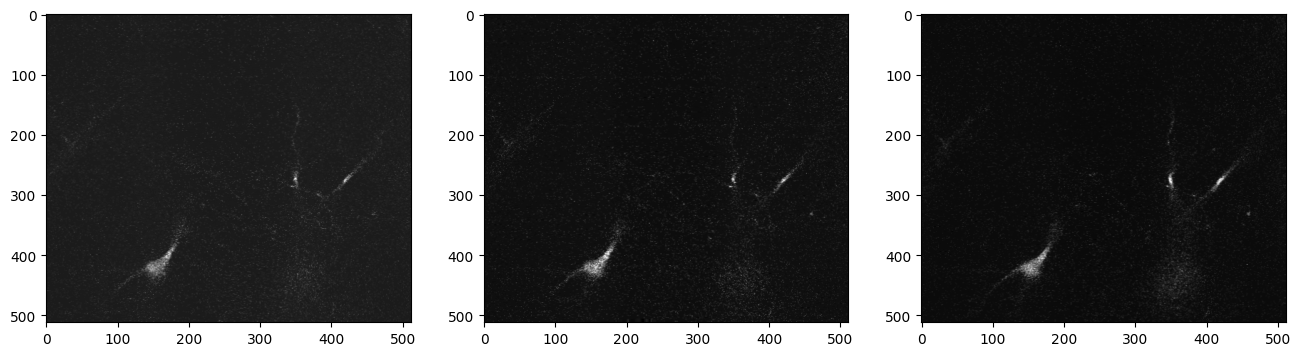

In [4]:
#quick viusal check

f, axs = plt.subplots(1, 3, sharex=True, figsize=(16, 4))
axs[0].imshow(imgs[100,:,:], cmap='Greys_r', aspect = 'auto')
axs[1].imshow(imgs[200,:,:], cmap='Greys_r', aspect = 'auto')
axs[2].imshow(imgs[300,:,:], cmap='Greys_r', aspect = 'auto')

###Autocorrelation in space


To analyse the noise structure in space, first, I extracted the noise by subtracting the mean frame
of video from 100 randomly selected frames, because we can assume that subtracting the mean
image from a given frame would return the noise profile of that frame – resulting in 100
randomly selected noise frames. Second, I measured the spatial correlation. For this, a given
noise frame and its copy was selected. Then copy of the noise frame was shifted from -30 to 30
on both x and y angles, then the mean correlation was calculated between the original and the
shifted noise frame. By shifting the image and measure correlation between the original, we
measure the translative (shifted by a vector in the Euclidian space) offset of an image (De Castro
& Morandi, 1987). Mean correlation was measured after every iteration (after every unit of
25
shifting), which resulted in a 61 x 61 matrix that contains the mean correlation coefficients on
the x and on the y angle of each iteration.

In [5]:
#calculating the mean

ave_im = np.mean(imgs, axis=0)

In [6]:
#list of random pictures

np.random.seed(12)

image_count = 100

random_numbers = np.random.choice(1000,image_count,False)

asd_list = [ imgs[random_numbers[x],:,:] - ave_im for x in range(image_count)]

In [7]:
#copying the list for further use

imgs_list = asd_list.copy()

In [8]:
#creating an empty matrix of 61x61 zeros for the function in the next cell

sp_acorr = np.zeros((61, 61))

In [9]:
#correlation function

def func_corr(pic):
    sp_corr = np.zeros((61, 61))
    for i in np.arange(-30, 30):
        for j in np.arange(-30, 30):

          p1 = 50+i
          p1_ = 450+i
          p2 = 50+j
          p2_ = 450+j
          ref_im = pic[50:450,50:450].flatten()
          sec_im = pic[p1:p1_,p2:p2_].flatten()

          m1 = np.mean(ref_im)
          m2 = np.mean(sec_im)
          sd1 = np.std(ref_im)
          sd2 = np.std(sec_im)


          sp_corr[i+30, j+30] = np.mean((ref_im - m1) * (sec_im - m2) / (sd1 * sd2))

    return(sp_corr)

In [10]:
#iterating funcacorr() over the list
#new_list = [funcacorr(x) for x in imgs_list]

new_imgs_list = []
i = 0
for x in imgs_list:
  print("Calculating %s th image" % i)
  i += 1
  new_imgs_list.append(func_corr(x))


Calculating 0 th image
Calculating 1 th image
Calculating 2 th image
Calculating 3 th image
Calculating 4 th image
Calculating 5 th image
Calculating 6 th image
Calculating 7 th image
Calculating 8 th image
Calculating 9 th image
Calculating 10 th image
Calculating 11 th image
Calculating 12 th image
Calculating 13 th image
Calculating 14 th image
Calculating 15 th image
Calculating 16 th image
Calculating 17 th image
Calculating 18 th image
Calculating 19 th image
Calculating 20 th image
Calculating 21 th image
Calculating 22 th image
Calculating 23 th image
Calculating 24 th image
Calculating 25 th image
Calculating 26 th image
Calculating 27 th image
Calculating 28 th image
Calculating 29 th image
Calculating 30 th image
Calculating 31 th image
Calculating 32 th image
Calculating 33 th image
Calculating 34 th image
Calculating 35 th image
Calculating 36 th image
Calculating 37 th image
Calculating 38 th image
Calculating 39 th image
Calculating 40 th image
Calculating 41 th image
Ca

In [11]:
spatial_cor_mean_per_frames = []
for i in range(100):
 spatial_cor_mean_per_frames.append(np.mean(new_imgs_list[i]))

len(spatial_cor_mean_per_frames)

100

Text(0, 0.5, 'Number of correlational coeffs.')

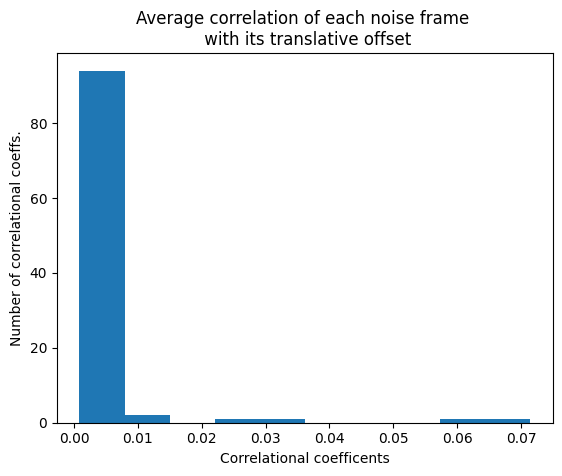

In [12]:
plt.hist(spatial_cor_mean_per_frames)
plt.title('Average correlation of each noise frame \n with its translative offset')
plt.xlabel('Correlational coefficents')
plt.ylabel('Number of correlational coeffs.')

In [13]:
scmpf = np.array(spatial_cor_mean_per_frames)
max(scmpf)

0.07145742198178623

In [14]:
avg_spatial_noise = np.zeros((61,61))

for k in range(len(new_imgs_list)):
  for x in range(61):
    for y in range(61):
      avg_spatial_noise[x][y] = avg_spatial_noise[x][y] + new_imgs_list[k][x][y] # vagy += (hozzáadjuk 0:100 irányban)
for x in range(61):
  for y in range(61):
    avg_spatial_noise[x][y] = avg_spatial_noise[x][y] / 100
print(np.shape(avg_spatial_noise))

(61, 61)


In [15]:
print(np.mean(avg_spatial_noise))

0.004867005494395019


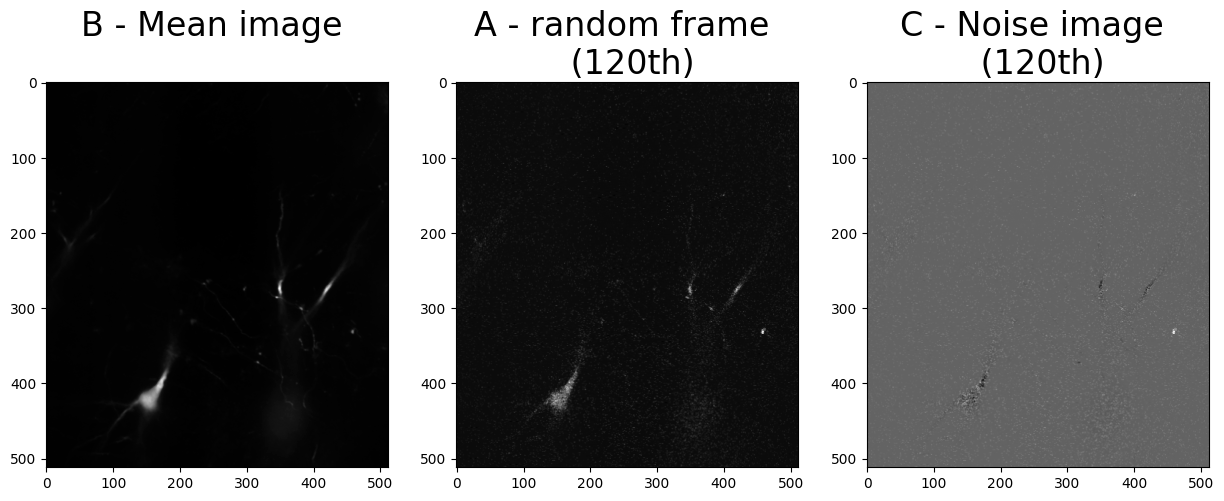

In [16]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(ave_im, cmap='Greys_r', aspect = 'auto')
axs[0].title.set_text('B - Mean image \n')
axs[0].title.set_size(24)
axs[1].imshow(imgs[120,:,:], cmap='Greys_r', aspect = 'auto')
axs[1].title.set_text('A - random frame \n (120th)')
axs[1].title.set_size(24)
axs[2].imshow(imgs[120,:,:] - ave_im, cmap='Greys_r', aspect = 'auto')
axs[2].title.set_text('C - Noise image \n (120th)')
axs[2].title.set_size(24)

A: Mean image of the recording. B: Randomly selected frame (120th) from the video of 1000 frame
length. C: Noise image of the 120th frame, which was calculated by subtracting the mean image of the video from
the 120th frame.

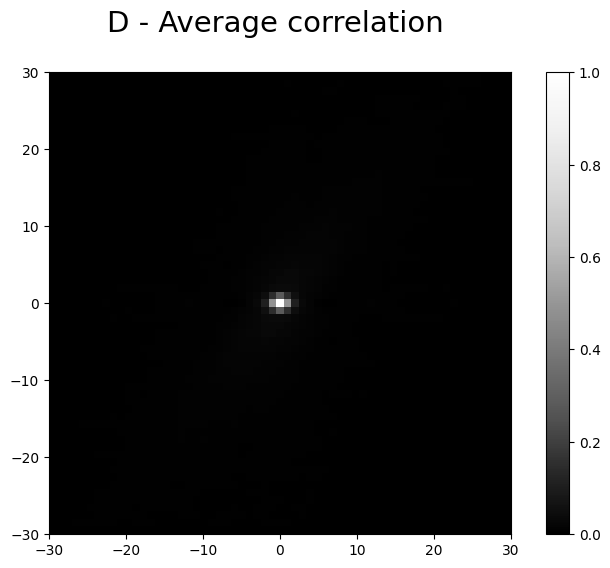

In [17]:
plt.figure(figsize=(9,6))

z = plt.imshow(avg_spatial_noise, extent=[-30,30,-30,30],cmap='Greys_r')
plt.title('D - Average correlation \n', fontsize = 21)
plt.xlim(-30, 30)
plt.ylim(-30, 30)

f.colorbar(z, orientation='vertical')
plt.show()

D: Average correlational matrix of the noise image (C) and its translational offset. The brightest
(white) pixels show full correlation (1) and darkest (black) pixels show no correlation. By every unit of shifting, the
correlation is measured between the given pixel and its neighbouring pixels. Since, the middle area of (white and
grey pixels) is very small, this image can be interpreted as there is no significant correlation between neighbouring
pixels. This means that the selected frame does not have any special characteristics regarding its spatial noise
structure (De Castro & Morandi, 1987).


In [18]:
centre = np.array(np.where(avg_spatial_noise == 1))
centre = centre.reshape(2*1)

In [19]:
centre

array([30, 30], dtype=int64)

In [20]:
distances = np.zeros(3721)
dist_corrcoeffs = np.zeros(3721)

k = 0
for y in range(0, avg_spatial_noise.shape[0]):  #looping through each rows
     for x in range(0, avg_spatial_noise.shape[1]): #looping through each column
          distances[k] = math.dist([x, y],centre)
          dist_corrcoeffs[k] = avg_spatial_noise[x, y]
          k = k + 1

In [21]:
dist_corrcoeffs[np.flatnonzero(distances == 1)]

array([0.48114904, 0.2864173 , 0.28641457, 0.48114541])

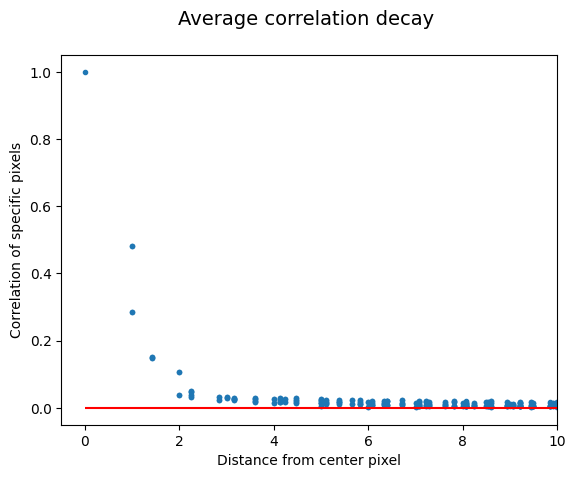

In [22]:
plt.plot(distances, dist_corrcoeffs, '.')
plt.title('Average correlation decay \n', fontsize = 14)
plt.xlabel('Distance from center pixel')
plt.ylabel('Correlation of specific pixels')
plt.xlim(-.5, 10)
plt.hlines(0, 0, 10, color='r')

D: Average correlational matrix of the noise image (C) and its translational offset. The brightest
(white) pixels show full correlation (1) and darkest (black) pixels show no correlation. By every unit of shifting, the
correlation is measured between the given pixel and its neighbouring pixels. Since, the middle area of (white and
grey pixels) is very small, this image can be interpreted as there is no significant correlation between neighbouring
pixels. This means that the selected frame does not have any special characteristics regarding its spatial noise
structure (De Castro & Morandi, 1987).


###Autocorrelation in time

D: Average correlational matrix of the noise image (C) and its translational offset. The brightest
(white) pixels show full correlation (1) and darkest (black) pixels show no correlation. By every unit of shifting, the
correlation is measured between the given pixel and its neighbouring pixels. Since, the middle area of (white and
grey pixels) is very small, this image can be interpreted as there is no significant correlation between neighbouring
pixels. This means that the selected frame does not have any special characteristics regarding its spatial noise
structure (De Castro & Morandi, 1987).


In [23]:
# noise_list = np.asarray(imgs)
# #first_pixel_coeffs = sm.tsa.acf(first_pixel, fft=False, nlags=1000)
# def autocorr(i,j):
#   autocorr_pixels = noise_list[:,i,j]
#   autocorr__mean_coeffs = sm.tsa.acf(autocorr_pixels, fft=False, nlags=1000)
#   return autocorr__mean_coeffs

In [24]:
pixel_i = np.random.randint(100, 300, 100)
pixel_j = np.random.randint(0, 200, 100)
acf100 = np.zeros((100, 1000))
for i_rep in np.arange(100):
    i = pixel_i[i_rep]
    j = pixel_j[i_rep]
    pixel_t = imgs[:,i,j]
    acf100[i_rep,:] = sm.tsa.acf(pixel_t, fft=False, nlags=1000)

In [25]:
avg_acf = np.mean(acf100, axis = 0)
len(avg_acf)

1000

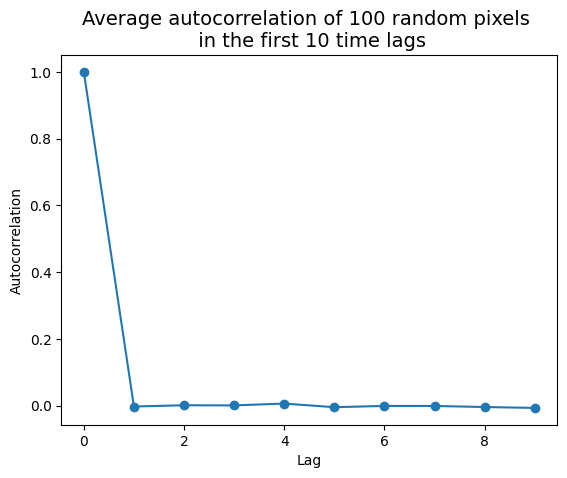

In [26]:
plt.plot(avg_acf[0:10], '-o')
plt.title('Average autocorrelation of 100 random pixels \n in the first 10 time lags', fontsize = 14)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Average autocorrelation of 100 randomly selected pixels – first 10-time lags. As we can see, there is almost no correlation in the time structure of noise. This means that the temporal structure has no special features
that can be measured by autocorrelation

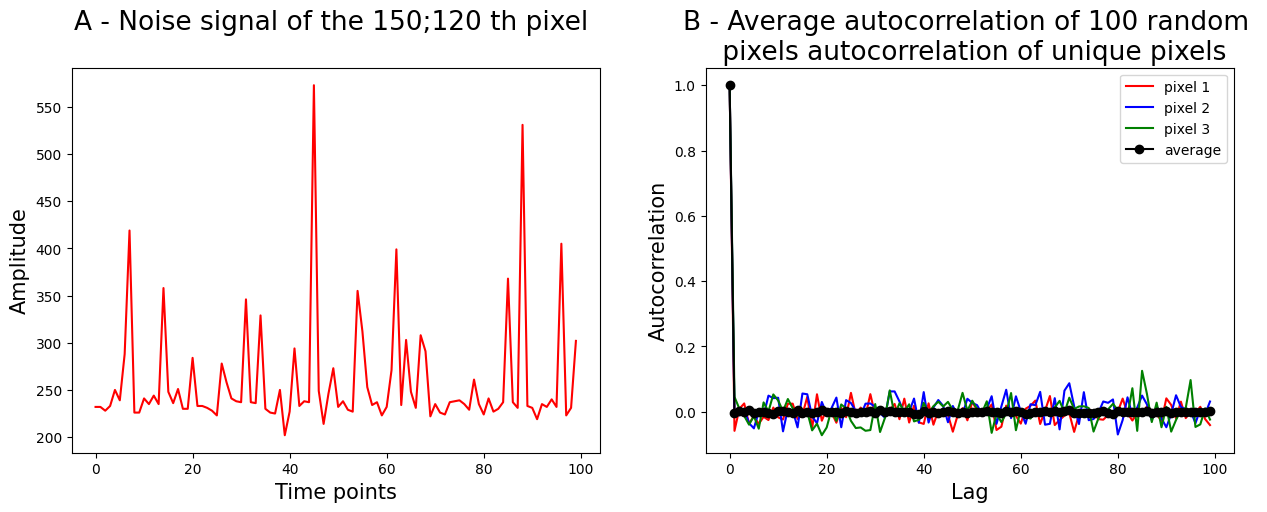

In [27]:
fig = plt.figure(figsize=(15,5))
lags = np.arange(1000)

rows = 1
columns = 2

#1
fig.add_subplot(rows, columns,  1)
plt.plot(imgs[0:100,pixel_i[0], pixel_j[0]], 'r')
plt.title('A - Noise signal of the 150;120 th pixel \n', fontsize = 19)
plt.xlabel('Time points', fontsize = 15)
plt.ylabel('Amplitude', fontsize = 15)

#2
fig.add_subplot(rows, columns, 2)
plt.plot(lags[0:100], acf100[0,0:100], '-r', label='pixel 1')
plt.plot(lags[0:100], acf100[1,0:100], '-b', label='pixel 2')
plt.plot(lags[0:100], acf100[2,0:100], '-g', label='pixel 3')
plt.plot(lags[0:100], avg_acf[0:100], '-ok', label='average')
plt.title('B - Average autocorrelation of 100 random \n pixels autocorrelation of unique pixels', fontsize = 19)
plt.xlabel('Lag', fontsize = 15)
plt.ylabel('Autocorrelation', fontsize = 15)
plt.legend()
plt.show()

As we can see the correlational coefficients in the correlation lags figure below, there is no any significant correlation between certain timepoints of given pixel. This can be interpreted as the following: due to the lack of any significant correlation in space and time between noise pixels, we can assume that noise structure of the neuronal recording has no special charateristic that could infer our later results.

## Measuring the standard deviation of the noise

In the next cell, I extract random pixels (100) from noise area then take their standard deviation and mean. These are the parameters that I need to appproach when I make the same calculations on synthetic data.

In [28]:
M = 100
noise_m_and_std = np.zeros((2, M))
noise_ij = np.zeros((2, M))
for m in np.arange(M):
    i = np.random.randint(200) + 100
    j = np.random.randint(200)
    noise_m_and_std[0,m] = np.mean(imgs[:,i,j])
    noise_m_and_std[1,m] = np.std(imgs[:,i,j])
    noise_ij[:,m] = [i,j]

Density of noise signals:

Text(0, 0.5, 'Estimated number of standard deviation values')

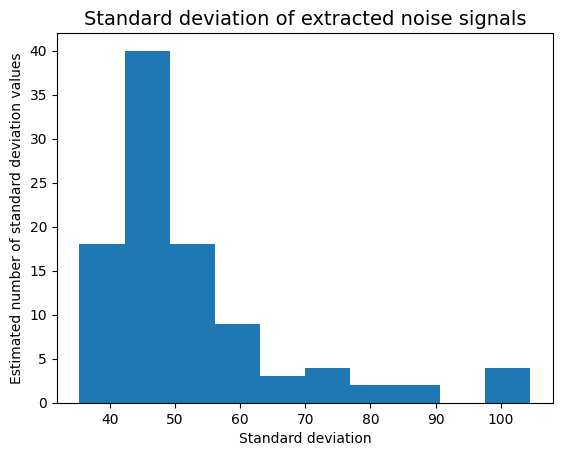

In [29]:
plt.hist(noise_m_and_std[1])
plt.title('Standard deviation of extracted noise signals', fontsize = 14)
plt.xlabel('Standard deviation')
plt.ylabel('Estimated number of standard deviation values')

In [30]:
print(np.mean(noise_m_and_std, axis=1))

[251.11519     52.84001682]


The average mean of noise is: 251
The average standard devation of noise is: 52